In [ ]:
import os
import sys
import glob

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from tqdm import tqdm
from itertools import cycle

from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import feature_selection

import lightgbm as lgb
import xgboost as xgb


pd.set_option("display.max_columns", None)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
train_df = pd.read_feather('/content/train_reduced.feather')
test_df = pd.read_feather('/content/test_reduced.feather')
train_labels = pd.read_csv("/content/train_labels.csv")
train_df.shape, test_df.shape

((2212580, 190), (2272752, 190))

In [ ]:
train_df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,b9cdf83627a38ebbfd8b8eb2c943f631fa18ea56731951...,2018-02-14,0.806641,0.008492,0.008804,0.812500,0.008385,NaN,0.000253,0.008980,NaN,NaN,0.009010,0.017166,0.629395,0.009659,0.000231,0.441406,0.599609,0.111450,NaN,0.203369,0.025284,0.002239,0.097839,0.335693,0.004925,0.003866,0.237549,0.653809,0.301514,0.003643,0.002874,0.005379,1.003906,1.001953,0.003138,NaN,0.014442,0.003569,0.101074,0.136353,0.006519,0.001082,0.000673,NaN,0.006111,0.459473,0.003023,0.247681,0.008759,0.285400,0.233643,1,1,0.002127,0.008522,NaN,1.000977,0.006939,-1,0.008255,6,0.192749,0.006229,0.008537,0.001562,0.003748,0.003197,0.003929,0.012810,0.002039,0.508789,0.011841,NaN,0.007103,0.009094,0.009941,NaN,0.007618,0.008125,0.218018,0.003433,0.008148,0.005119,0.003059,0.005074,NaN,0.001828,0.005692,0.008499,0.005508,0.003078,0.004684,NaN,0.005791,1.007812,0.026398,0.009972,0.008698,0.008850,0.000056,0.004700,0.002716,NaN,0,0.001182,0.002857,NaN,0.004364,0.001912,NaN,1.0,0.009766,0.000813,0.004581,0.003746,0.003551,0.008018,1.003906,0.006336,0.000690,0.003494,0.004925,0.006710,0.004765,0.001199,0.009865,0.008316,0.008568,0.297119,0.134644,0.080261,0.973633,0.003553,0.009132,0.008293,0.005592,NaN,NaN,0.005493,0.004768,0.002541,NaN,1.004883,1,NaN,0.006577,NaN,NaN,NaN,1.003906,0.018875,NaN,0.000050,1,0.310303,0,3,0.308838,0.311035,0,0.687012,0.716309,0.009140,0.142456,0.009621,0,0.005295,1.000977,1.004883,0.008598,NaN,0.006790,0.004341,NaN,0.009529,0.005444,NaN,NaN,NaN,NaN,NaN,0.008713,0.006947,0.001535,NaN,0.002403,0.007988,0.005600
1,0b1ecd1e9fd72ebf6e3188c581e90de0210c1d3133b231...,2017-07-08,1.000000,0.002527,0.007206,0.814453,0.003199,NaN,0.005241,0.004757,NaN,NaN,0.005489,0.020645,0.481934,0.003489,0.007130,0.383545,0.921387,0.026047,NaN,0.197754,0.023911,0.009285,0.052948,0.003864,0.007168,0.006855,0.451904,0.659180,0.299561,NaN,0.005157,0.006626,1.007812,1.003906,0.003252,NaN,0.005825,0.006893,0.051758,0.067688,0.009026,0.004738,0.015144,NaN,0.009842,0.340576,0.005116,0.003937,0.006729,0.287842,0.254150,1,1,0.002405,0.003098,NaN,0.692871,0.004143,-1,0.005234,6,0.187012,0.009850,0.009666,0.000567,0.007793,0.005619,0.009941,0.009163,0.008347,0.504883,0.019394,NaN,0.003944,0.074219,0.075562,NaN,0.009399,0.007492,0.235229,0.003704,0.008125,0.002892,0.006794,0.005054,NaN,0.000698,0.002615,0.002609,0.002028,0.006691,0.000715,NaN,0.004700,1.007812,0.028000,0.008904,0.007805,0.007339,0.009872,0.007256,0.000902,NaN,0,0.008080,0.003187,NaN,0.004818,0.006424,NaN,1.0,0.007904,0.006481,0.000469,0.001239,0.008369,0.008675,1.003906,0.002260,0.004166,0.000272,0.000908,0.000654,0.004223,0.005447,0.002600,0.000782,0.007835,0.299805,0.135132,0.083374,0.972168,0.003960,0.048035,1.001953,0.953613,0.023651,NaN,0.342285,0.009254,0.000323,NaN,1.003906,1,NaN,0.005165,NaN,NaN,NaN,1.001953,0.016220,NaN,0.003056,1,0.555664,0,2,0.556641,0.554688,0,0.803711,0.576660,0.007103,0.228394,0.007122,1,0.000417,1.005859,1.009766,0.000221,NaN,0.001495,0.001849,NaN,0.003075,0.007793,NaN,NaN,NaN,NaN,NaN,0.000873,0.008888,0.002413,NaN,0.003

Target Distribution


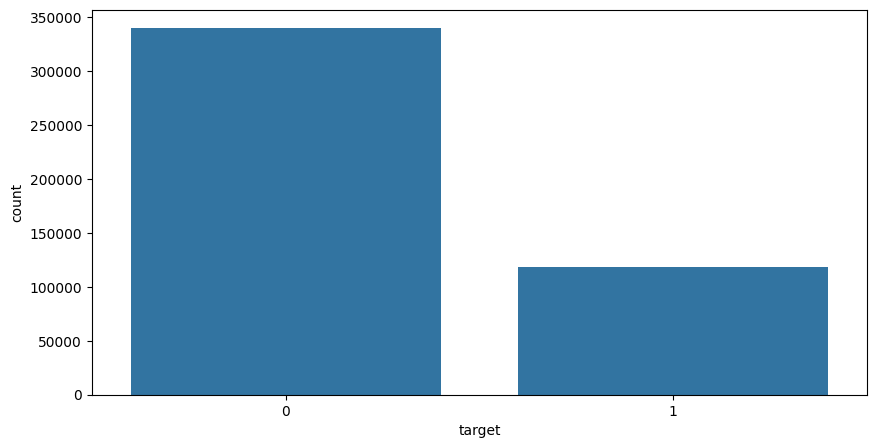

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x=train_labels.target)
plt.show()

0 --> Non Default
1 --> Default

### EDA

In [ ]:
# s_2 date featue
train_df['S_2'] = pd.to_datetime(train_df['S_2'])
test_df['S_2'] = pd.to_datetime(test_df['S_2'])

train_df['S_2'].min(), train_df['S_2'].max()

(Timestamp('2017-03-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [ ]:
test_df['S_2'].min(), test_df['S_2'].max()

(Timestamp('2018-04-01 00:00:00'), Timestamp('2019-10-31 00:00:00'))

In [ ]:
#time line also not intersected

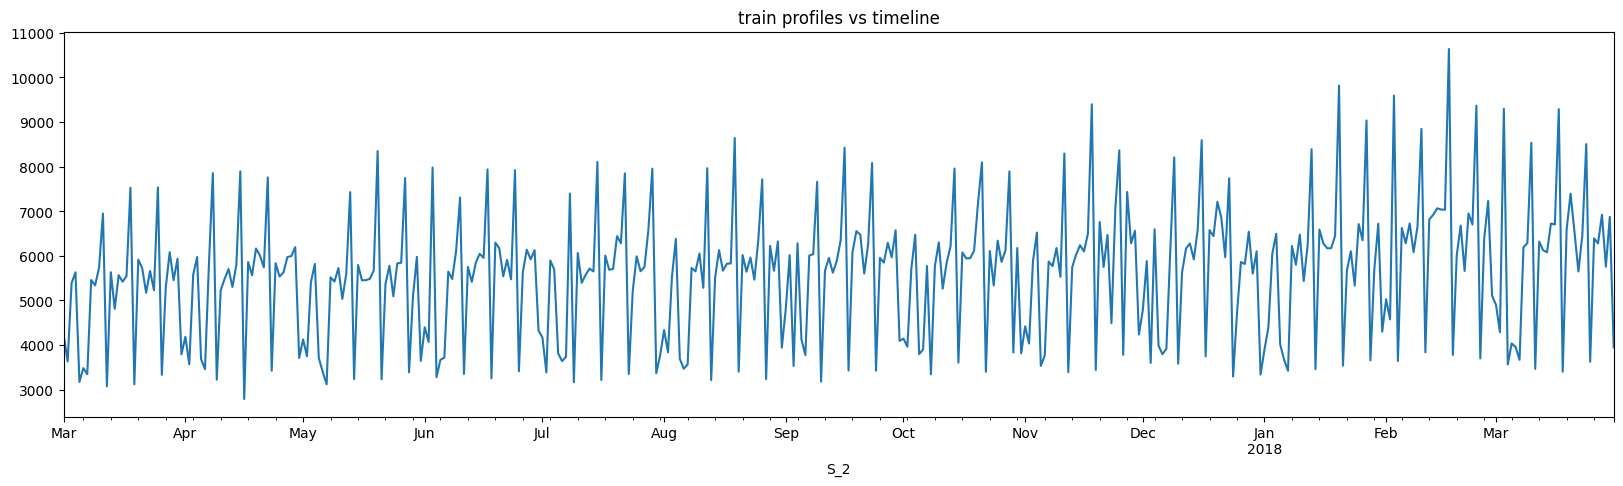

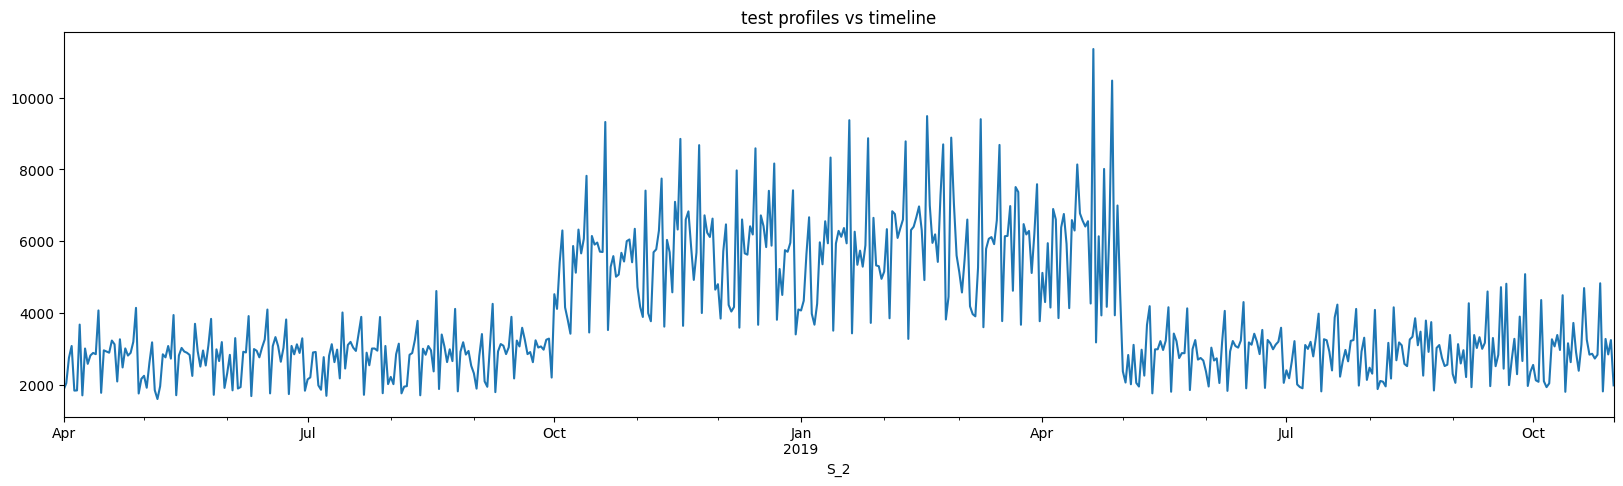

In [ ]:
# checking user profiles number of user profiles vs timeline

fig, ax = plt.subplots(figsize=(20,5))
train_df.groupby("S_2")['customer_ID'].count().plot()
plt.title("train profiles vs timeline")
plt.show()

fig, ax = plt.subplots(figsize=(20,5))
test_df.groupby("S_2")['customer_ID'].count().plot()
plt.title("test profiles vs timeline")
plt.show()

In [ ]:
#we can observe that train profiles are consistence
#but test profiles increased between oct to apr

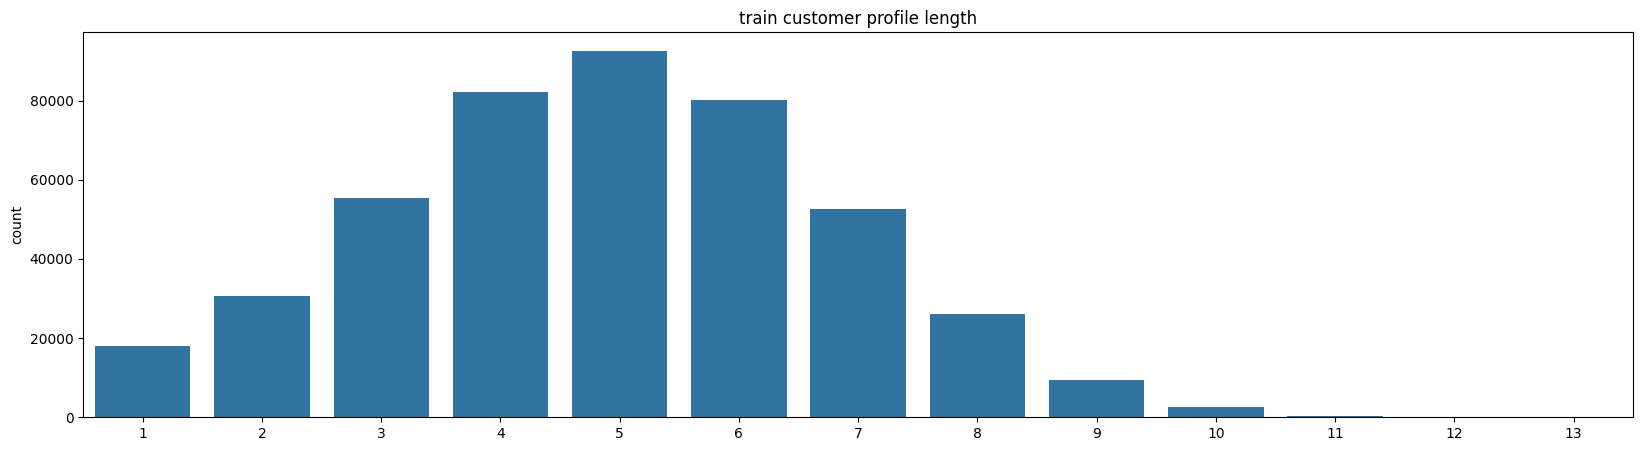

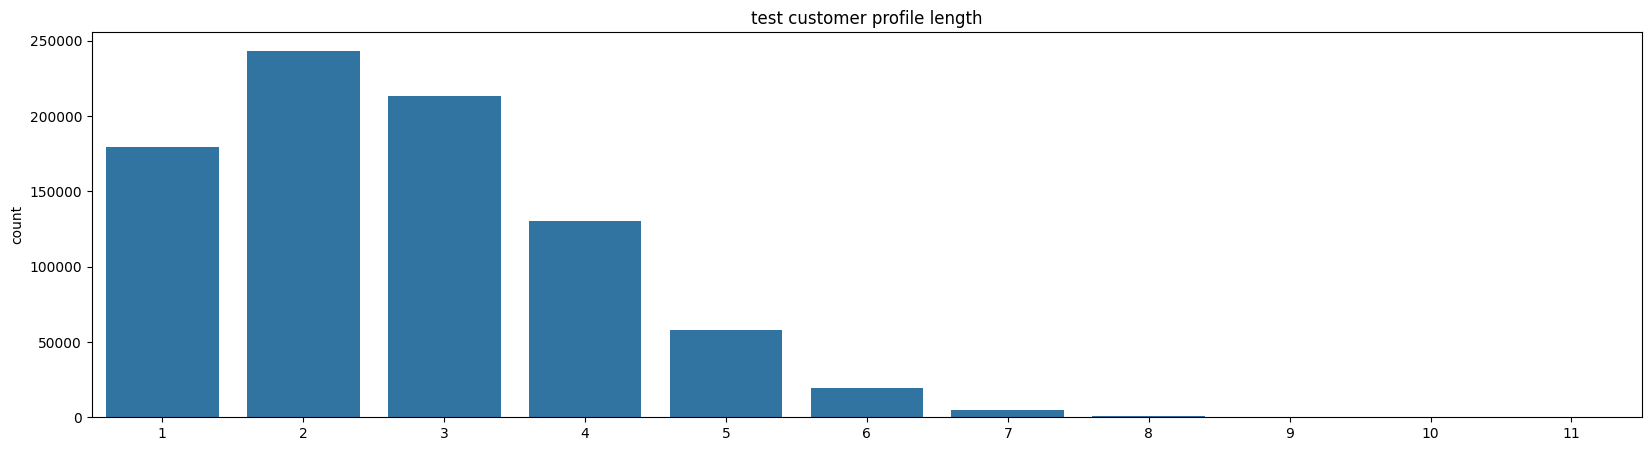

In [ ]:
# check each customer profile length

fig, ax = plt.subplots(figsize=(20,5))
sns.countplot(x=train_df.groupby("customer_ID")['customer_ID'].count().values)
plt.title("train customer profile length")
plt.show()

fig, ax = plt.subplots(figsize=(20,5))
sns.countplot(x=test_df.groupby("customer_ID")['customer_ID'].count().values)
plt.title("test customer profile length")
plt.show()

In [ ]:
#we can observe that train and test profile lengths are similar distributions

## Weight of Evidence(WOE)

The weight of evidence tells the predictive power of an independent variable in relation to the dependent variable. It is generally described as a measure of the separation of customers who returned loan and customers who didn't.

In [ ]:
# WOE = ln ( Distribution of good customers/ Distribution of bas customers)

## Information Value(IV)

Information value is one of the most useful technique to select important variables in a predictive model. It helps to rank variables on the basis of their importance.

In [ ]:
# IV = sum of (% of non-events - % of events) * WOE

## Feature Selection


In [ ]:
# Training data preparation
# taking latest profile features for each customer

train_df = train_df.groupby("customer_ID").tail(1).reset_index(drop=True)
test_df = test_df.groupby("customer_ID").tail(1).reset_index(drop=True)

In [ ]:
# Merge with targets
train_df = train_df.merge(train_labels, on='customer_ID', how='left')

In [ ]:
target_col = 'target'
drop_cols = ['customer_ID', 'S_2', target_col]
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
train_cols = [col for col in train_df.columns if col not in drop_cols]

For selecting features we are calculating IV values for each feature.
For this, being a continuous variable, split data into 10 parts. We'd be using optbinning

In [ ]:
!pip -q install optbinning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.5/213.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 17.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.6 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
google-cloud-datastore 2.19.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
google-cloud-firestore 2.16.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5

In [ ]:
import optbinning

(CVXPY) Oct 14 07:15:24 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Oct 14 07:15:24 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [ ]:
iv_score_dict = {}
for col in tqdm(train_cols):
    if col in cat_cols:
        optb = optbinning.OptimalBinning(dtype='categorical')
        optb.fit(train_df[col], train_df['target'])
    else:
        optb = optbinning.OptimalBinning(dtype='numerical')
        optb.fit(train_df[col], train_df['target'])
    binning_table = optb.binning_table
    binning_table.build()
    iv_score_dict[col] = binning_table.iv

iv_score_df = pd.Series(iv_score_dict)
iv_score_df.sort_values(ascending=False, inplace=True)

100%|██████████| 188/188 [02:24<00:00,  1.30it/s]


In [ ]:
# top 10 imp iv features
iv_score_df.head(10)

,0
P_2,2.952865
D_48,1.777136
D_61,1.579138
D_75,1.514600
B_18,1.480359
B_7,1.479162
D_62,1.430638
B_10,1.429336
B_23,1.424171
D_44,1.409099


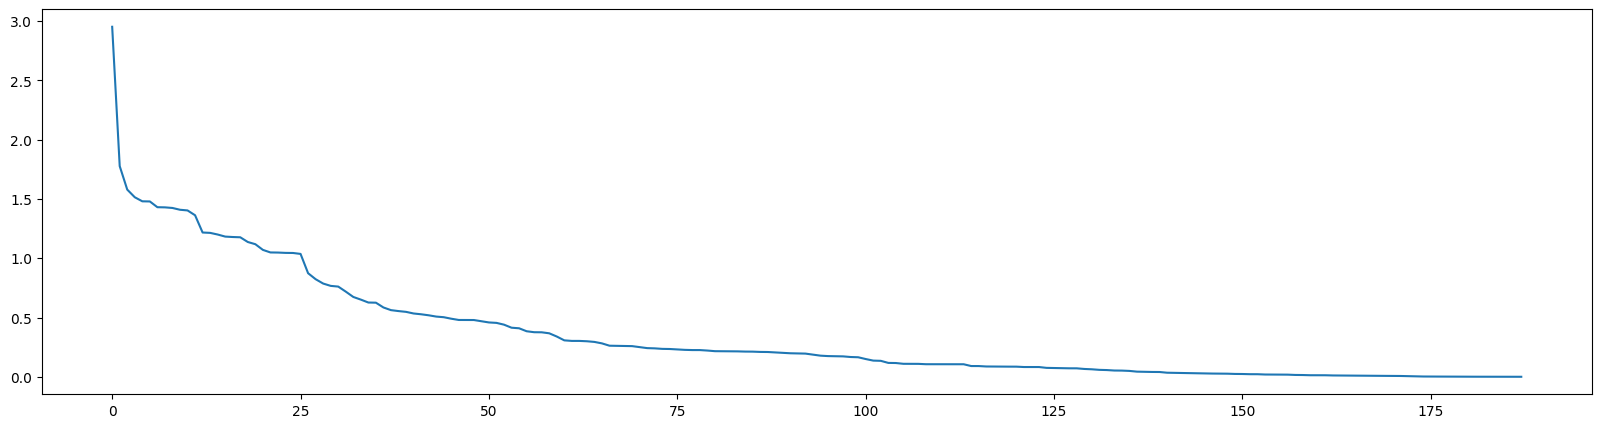

In [ ]:
# iv score vs features
fig, ax = plt.subplots(figsize=(20,5))
iv_score_df.reset_index(drop=True).plot()
plt.show()

We can observe that top 75 features have > 0.5 IV value, So those top 75 IV value features are strong predictors

In [ ]:
col = 'P_2'
optb = optbinning.OptimalBinning(dtype='numerical')
optb.fit(train_df[col], train_df['target'])
binning_table = optb.binning_table
display(binning_table.build())

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.24)",25204,0.055964,4472,20732,0.822568,-2.593234,0.429060,0.042342
1,"[0.24, 0.33)",22574,0.050124,6615,15959,0.706964,-1.940075,0.228688,0.024807
2,"[0.33, 0.39)",26165,0.058098,9290,16875,0.644946,-1.656286,0.195074,0.021931
3,"[0.39, 0.47)",38441,0.085356,17115,21326,0.554772,-1.279363,0.169864,0.019894
4,"[0.47, 0.56)",43771,0.097191,25442,18329,0.418748,-0.731475,0.059997,0.007337
5,"[0.56, 0.62)",34219,0.075982,24764,9455,0.276308,-0.096544,0.000725,0.000091
6,"[0.62, 0.69)",33116,0.073532,27590,5526,0.166868,0.548598,0.019110,0.002359
7,"[0.69, 0.73)",24223,0.053786,21842,2381,0.098295,1.156923,0.051801,0.006137
8,"[0.73, 0.77)",22635,0.050260,21286,1349,0.059598,1.699294,0.088386,0.009885
9,"[0.77, 0.83)",42008,0.093277,40657,1351,0.032161,2.344934,0.257754,0.026412


- P_2 is a continuous feature, os we splited into 15 bins
- Each bin have non-event and event counts and rates
- Each bin have WOE and IV values
- For missing values it's created 16th bin

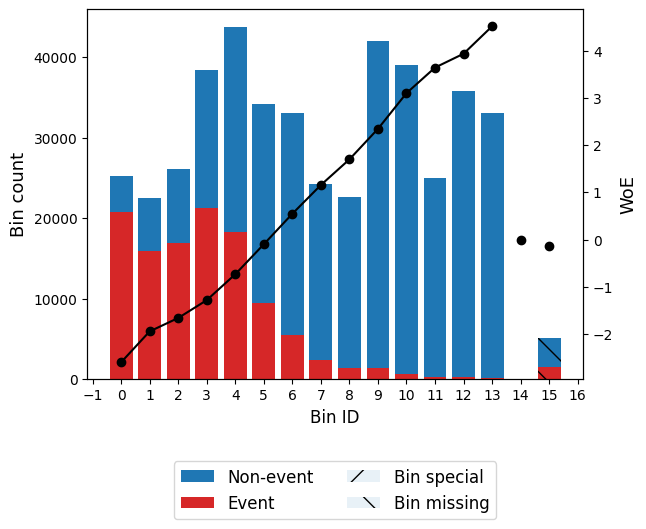

None

In [ ]:
display(binning_table.plot(metric="woe"))

----------------------------------------------------------------------------------------------------
################ Feature Name :  P_2





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.24)",25204,0.055964,4472,20732,0.822568,-2.593234,0.429060,0.042342
1,"[0.24, 0.33)",22574,0.050124,6615,15959,0.706964,-1.940075,0.228688,0.024807
2,"[0.33, 0.39)",26165,0.058098,9290,16875,0.644946,-1.656286,0.195074,0.021931
3,"[0.39, 0.47)",38441,0.085356,17115,21326,0.554772,-1.279363,0.169864,0.019894
4,"[0.47, 0.56)",43771,0.097191,25442,18329,0.418748,-0.731475,0.059997,0.007337
5,"[0.56, 0.62)",34219,0.075982,24764,9455,0.276308,-0.096544,0.000725,0.000091
6,"[0.62, 0.69)",33116,0.073532,27590,5526,0.166868,0.548598,0.019110,0.002359
7,"[0.69, 0.73)",24223,0.053786,21842,2381,0.098295,1.156923,0.051801,0.006137
8,"[0.73, 0.77)",22635,0.050260,21286,1349,0.059598,1.699294,0.088386,0.009885
9,"[0.77, 0.83)",42008,0.093277,40657,1351,0.032161,2.344934,0.257754,0.026412


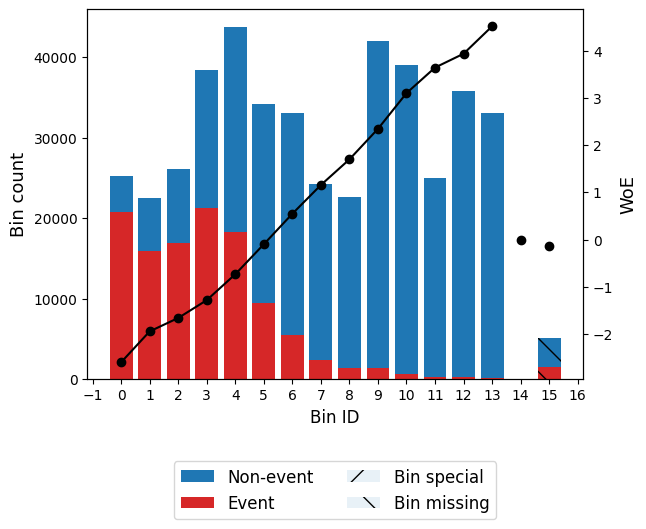

None

----------------------------------------------------------------------------------------------------
################ Feature Name :  D_48





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.03)",36762,0.081628,36019,743,0.020211,2.821714,0.285827,0.027209
1,"[0.03, 0.05)",24888,0.055263,24258,630,0.025313,2.59139,0.173888,0.017165
2,"[0.05, 0.07)",23138,0.051377,22444,694,0.029994,2.416915,0.147736,0.014977
3,"[0.07, 0.10)",24580,0.054579,23572,1008,0.041009,2.0927,0.129309,0.013739
4,"[0.10, 0.14)",23530,0.052247,22185,1345,0.057161,1.743631,0.095440,0.010617
5,"[0.14, 0.23)",41513,0.092178,37469,4044,0.097415,1.166888,0.090035,0.010656
6,"[0.23, 0.32)",29350,0.065170,24081,5269,0.179523,0.460191,0.012222,0.001514
7,"[0.32, 0.43)",28604,0.063514,20841,7763,0.271396,-0.071838,0.000333,0.000042
8,"[0.43, 0.57)",34529,0.076670,21726,12803,0.370790,-0.530561,0.024124,0.002981
9,"[0.57, 0.72)",37797,0.083926,19645,18152,0.480250,-0.980349,0.095907,0.011530


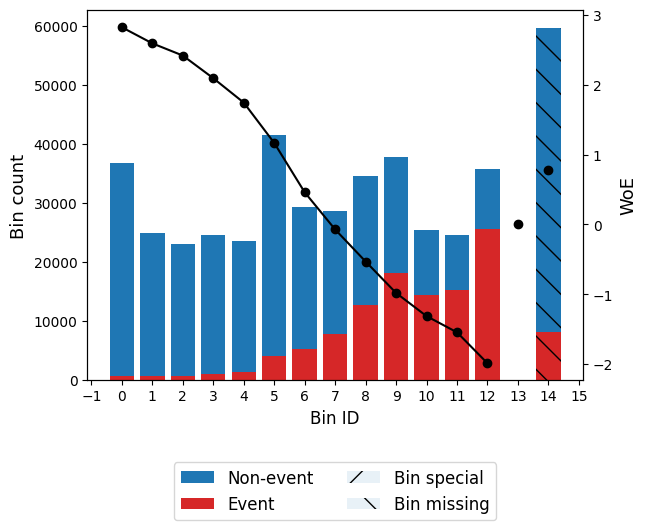

None

----------------------------------------------------------------------------------------------------
################ Feature Name :  D_61





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.04)",50452,0.112026,49085,1367,0.027095,2.521543,0.340366,0.033962
1,"[0.04, 0.07)",29719,0.065990,28856,863,0.029039,2.450267,0.193183,0.019486
2,"[0.07, 0.12)",32881,0.073011,31343,1538,0.046775,1.955117,0.157301,0.017029
3,"[0.12, 0.17)",22840,0.050715,21199,1641,0.071848,1.499257,0.073816,0.008450
4,"[0.17, 0.24)",24512,0.054428,21789,2723,0.111088,1.020279,0.042511,0.005095
5,"[0.24, 0.38)",39468,0.087637,31372,8096,0.205128,0.295154,0.007077,0.000881
6,"[0.38, 0.49)",27698,0.061502,20209,7489,0.270381,-0.066699,0.000278,0.000035
7,"[0.49, 0.60)",25138,0.055818,16690,8448,0.336065,-0.378512,0.008692,0.001080
8,"[0.60, 0.69)",23337,0.051819,14264,9073,0.388782,-0.606956,0.021612,0.002661
9,"[0.69, 0.78)",26551,0.058955,14930,11621,0.437686,-0.808833,0.044966,0.005472


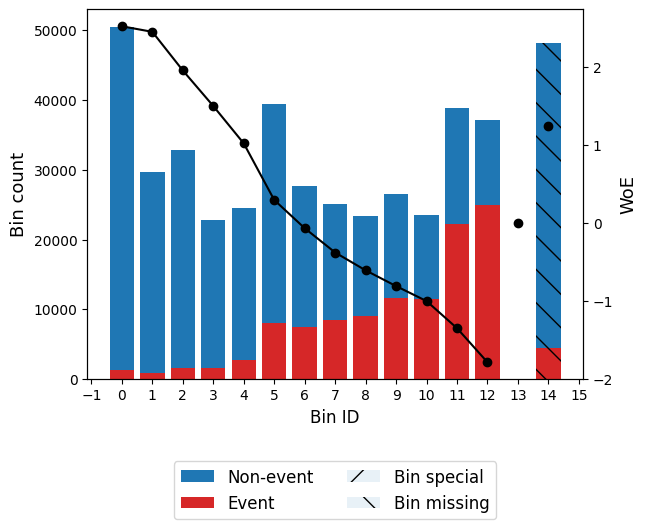

None

----------------------------------------------------------------------------------------------------
################ Feature Name :  D_75





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.04)",166132,0.368888,158869,7263,0.043718,2.025895,0.835486,0.089589
1,"[0.04, 0.07)",51482,0.114313,43382,8100,0.157337,0.618789,0.037037,0.004557
2,"[0.07, 0.10)",24071,0.053448,20164,3907,0.162311,0.581737,0.015471,0.001907
3,"[0.10, 0.20)",51339,0.113996,36342,14997,0.292117,-0.174268,0.003605,0.000450
4,"[0.20, 0.24)",39095,0.086809,23970,15125,0.386878,-0.598938,0.035210,0.004337
5,"[0.24, 0.33)",29931,0.066460,16018,13913,0.464836,-0.918502,0.066234,0.008000
6,"[0.33, 0.40)",23177,0.051463,11279,11898,0.513354,-1.112819,0.076674,0.009118
7,"[0.40, 0.54)",37962,0.084293,15610,22352,0.588799,-1.418396,0.207259,0.023933
8,"[0.54, inf)",27170,0.060330,8791,18379,0.676445,-1.796872,0.237624,0.026258
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


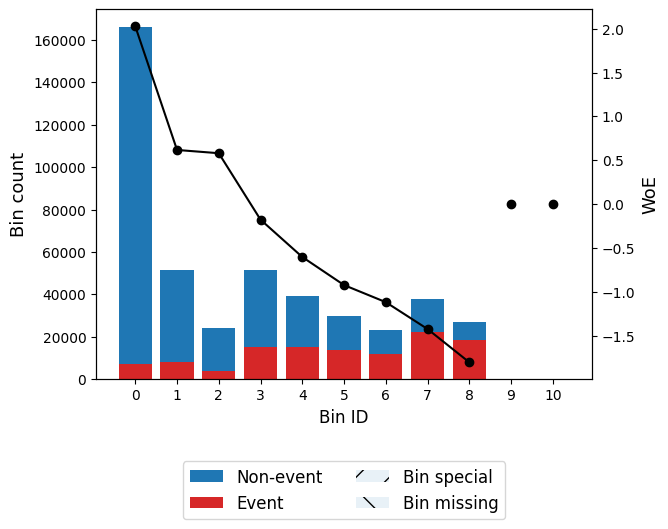

None

----------------------------------------------------------------------------------------------------
################ Feature Name :  B_18





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.07)",28762,0.063865,12234,16528,0.574647,-1.360229,0.144159,0.016748
1,"[0.07, 0.19)",61172,0.135829,27005,34167,0.558540,-1.29463,0.276999,0.032393
2,"[0.19, 0.24)",38841,0.086245,18792,20049,0.516181,-1.12414,0.131235,0.015592
3,"[0.24, 0.33)",22600,0.050182,12959,9641,0.426593,-0.763626,0.033912,0.004139
4,"[0.33, 0.53)",28625,0.063560,20031,8594,0.300227,-0.213175,0.003034,0.000379
5,"[0.53, 0.61)",37267,0.082750,29003,8264,0.221751,0.196099,0.003028,0.000378
6,"[0.61, 0.65)",33393,0.074148,27211,6182,0.185129,0.422588,0.011851,0.001470
7,"[0.65, 0.85)",33559,0.074516,28082,5477,0.163205,0.57518,0.021126,0.002605
8,"[0.85, 1.01)",89269,0.198217,85480,3789,0.042445,2.056789,0.458500,0.048958
9,"[1.01, inf)",76871,0.170688,73628,3243,0.042188,2.063135,0.396514,0.042302


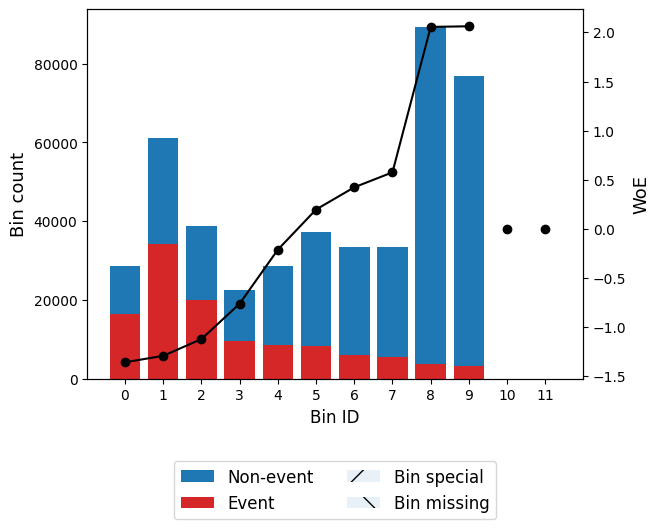

None

----------------------------------------------------------------------------------------------------
################ Feature Name :  B_7





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.03)",126775,0.281498,121680,5095,0.040189,2.113743,0.676189,0.071634
1,"[0.03, 0.04)",30222,0.067106,28664,1558,0.051552,1.852847,0.133910,0.014692
2,"[0.04, 0.05)",36798,0.081708,33405,3393,0.092206,1.2276,0.086695,0.010204
3,"[0.05, 0.08)",30650,0.068057,25689,4961,0.161860,0.585064,0.019906,0.002453
4,"[0.08, 0.11)",24987,0.055482,19015,5972,0.239004,0.098755,0.000528,0.000066
5,"[0.11, 0.14)",22728,0.050466,15785,6943,0.305482,-0.238065,0.003020,0.000377
6,"[0.14, 0.18)",23589,0.052378,14984,8605,0.364789,-0.504752,0.014849,0.001837
7,"[0.18, 0.27)",39688,0.088125,22754,16934,0.426678,-0.763974,0.059610,0.007275
8,"[0.27, 0.35)",29148,0.064722,15187,13961,0.478969,-0.97522,0.073151,0.008798
9,"[0.35, 0.50)",34107,0.075733,16050,18057,0.529422,-1.177216,0.126856,0.015000


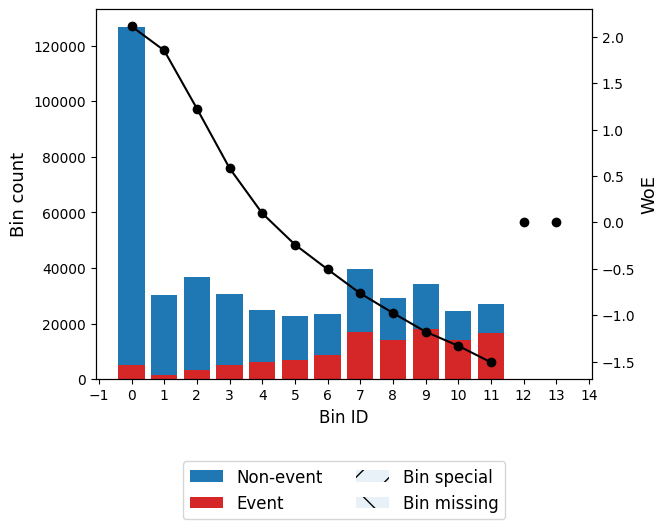

None

----------------------------------------------------------------------------------------------------
################ Feature Name :  D_62





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.01)",26984,0.059917,9325,17659,0.654425,-1.697938,0.211284,0.023635
1,"[0.01, 0.02)",27242,0.060490,10820,16422,0.602819,-1.476617,0.161388,0.018520
2,"[0.02, 0.02)",22533,0.050033,10265,12268,0.544446,-1.237646,0.092977,0.010933
3,"[0.02, 0.03)",22785,0.050593,11540,11245,0.493526,-1.033496,0.064581,0.007732
4,"[0.03, 0.05)",43062,0.095617,25128,17934,0.416469,-0.722107,0.057446,0.007029
5,"[0.05, 0.08)",38275,0.084988,25883,12392,0.323762,-0.322856,0.009522,0.001185
6,"[0.08, 0.11)",23918,0.053109,17606,6312,0.263902,-0.033604,0.000060,0.000008
7,"[0.11, 0.16)",34493,0.076590,28213,6280,0.182066,0.443021,0.013377,0.001659
8,"[0.16, 0.25)",41405,0.091938,37641,3764,0.090907,1.24322,0.099567,0.011702
9,"[0.25, 0.32)",22576,0.050129,21431,1145,0.050718,1.870042,0.101369,0.011097


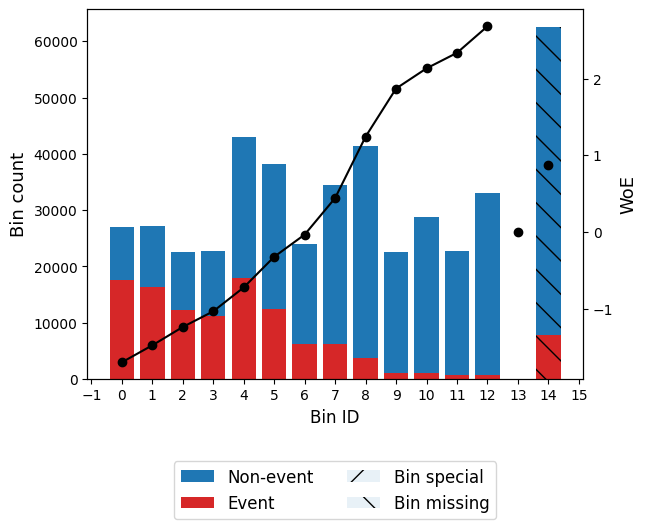

None

----------------------------------------------------------------------------------------------------
################ Feature Name :  B_10





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.01)",30784,0.068354,14223,16561,0.537974,-1.211582,0.121544,0.014327
1,"[0.01, 0.02)",44488,0.098783,21077,23411,0.526232,-1.164415,0.161748,0.019148
2,"[0.02, 0.02)",23262,0.051652,11400,11862,0.509930,-1.099118,0.074991,0.008929
3,"[0.02, 0.04)",36207,0.080396,19361,16846,0.465269,-0.920244,0.080442,0.009715
4,"[0.04, 0.06)",40220,0.089307,24234,15986,0.397464,-0.643348,0.042090,0.005172
5,"[0.06, 0.08)",32975,0.073219,22621,10354,0.313995,-0.277886,0.006021,0.000750
6,"[0.08, 0.14)",34431,0.076452,26499,7932,0.230374,0.14681,0.001588,0.000198
7,"[0.14, 0.21)",22555,0.050082,18849,3706,0.164309,0.567115,0.013835,0.001707
8,"[0.21, 0.25)",29390,0.065259,25922,3468,0.117999,0.952122,0.045320,0.005460
9,"[0.25, 0.29)",25052,0.055627,23770,1282,0.051174,1.860611,0.111672,0.012240


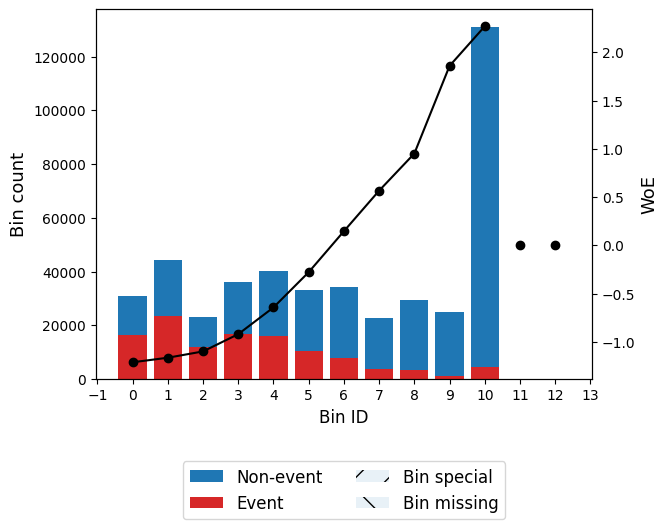

None

----------------------------------------------------------------------------------------------------
################ Feature Name :  B_23





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.02)",136661,0.303449,130601,6060,0.044343,2.011045,0.680242,0.073090
1,"[0.02, 0.03)",26816,0.059544,25158,1658,0.061829,1.660172,0.101148,0.011366
2,"[0.03, 0.04)",32835,0.072909,29626,3209,0.097731,1.163301,0.070855,0.008389
3,"[0.04, 0.06)",27287,0.060589,22915,4372,0.160223,0.59718,0.018399,0.002266
4,"[0.06, 0.09)",28127,0.062455,21384,6743,0.239734,0.094746,0.000548,0.000068
5,"[0.09, 0.12)",22709,0.050424,15601,7108,0.313004,-0.273277,0.004006,0.000499
6,"[0.12, 0.16)",24351,0.054070,15479,8872,0.364338,-0.502808,0.015205,0.001881
7,"[0.16, 0.26)",42062,0.093397,23926,18136,0.431173,-0.782325,0.066412,0.008096
8,"[0.26, 0.38)",37781,0.083891,19110,18671,0.494190,-1.036151,0.107662,0.012886
9,"[0.38, 0.51)",26416,0.058655,12175,14241,0.539105,-1.216132,0.105112,0.012385


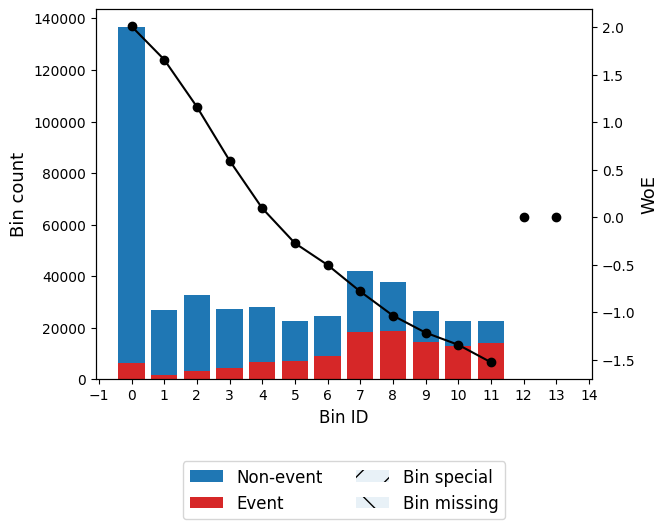

None

----------------------------------------------------------------------------------------------------
################ Feature Name :  D_44





,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.00)",50037,0.111105,45277,4760,0.095130,1.19316,0.112550,1.328950e-02
1,"[0.00, 0.00)",73810,0.163891,66723,7087,0.096017,1.182896,0.163696,1.934673e-02
2,"[0.00, 0.01)",22536,0.050040,20370,2166,0.096113,1.18179,0.049904,5.898587e-03
3,"[0.01, 0.07)",130054,0.288779,117478,12576,0.096698,1.175069,0.285316,3.374461e-02
4,"[0.07, 0.13)",22794,0.050613,13570,9224,0.404668,-0.673339,0.026250,3.220683e-03
5,"[0.13, 0.19)",38533,0.085561,22567,15966,0.414346,-0.713364,0.050104,6.133498e-03
6,"[0.19, 0.26)",31522,0.069993,13536,17986,0.570586,-1.343632,0.154067,1.792903e-02
7,"[0.26, 0.44)",22591,0.050162,8100,14491,0.641450,-1.641055,0.165374,1.862549e-02
8,"[0.44, inf)",34879,0.077447,9253,25626,0.734711,-2.078051,0.401835,4.278143e-02
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00


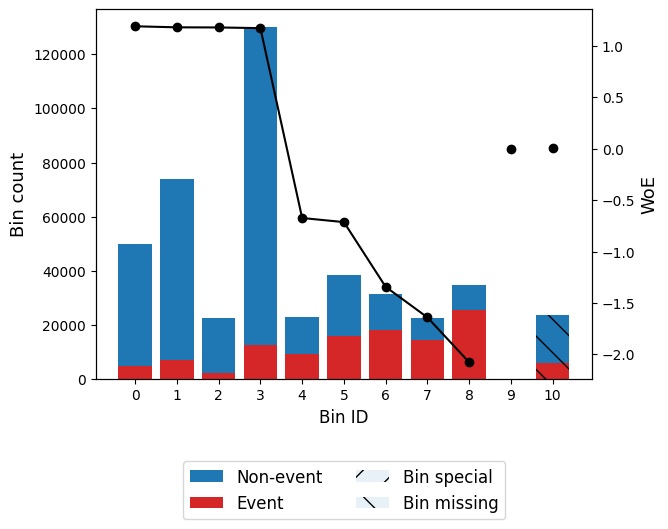

None

In [ ]:
top10_features = iv_score_df[:10].index.values

for col in top10_features:
    print("-"*100)
    print("="*100)
    print("################ Feature Name : ", col)
    print("\n\n")

    if col in cat_cols:
        optb = optbinning.OptimalBinning(dtype='categorical')
        optb.fit(train_df[col], train_df['target'])
    else:
        optb = optbinning.OptimalBinning(dtype='numerical')
        optb.fit(train_df[col], train_df['target'])

    binning_table = optb.binning_table
    display(binning_table.build())
    display(binning_table.plot(metric="woe"))


selecting features IV values > 0.5

In [ ]:
selected_features = iv_score_df[iv_score_df > 0.5].index.values
cat_cols = [col for col in cat_cols if col in selected_features]
train_cols = [col for col in train_df.columns if col in selected_features]

Correlation Heatmap

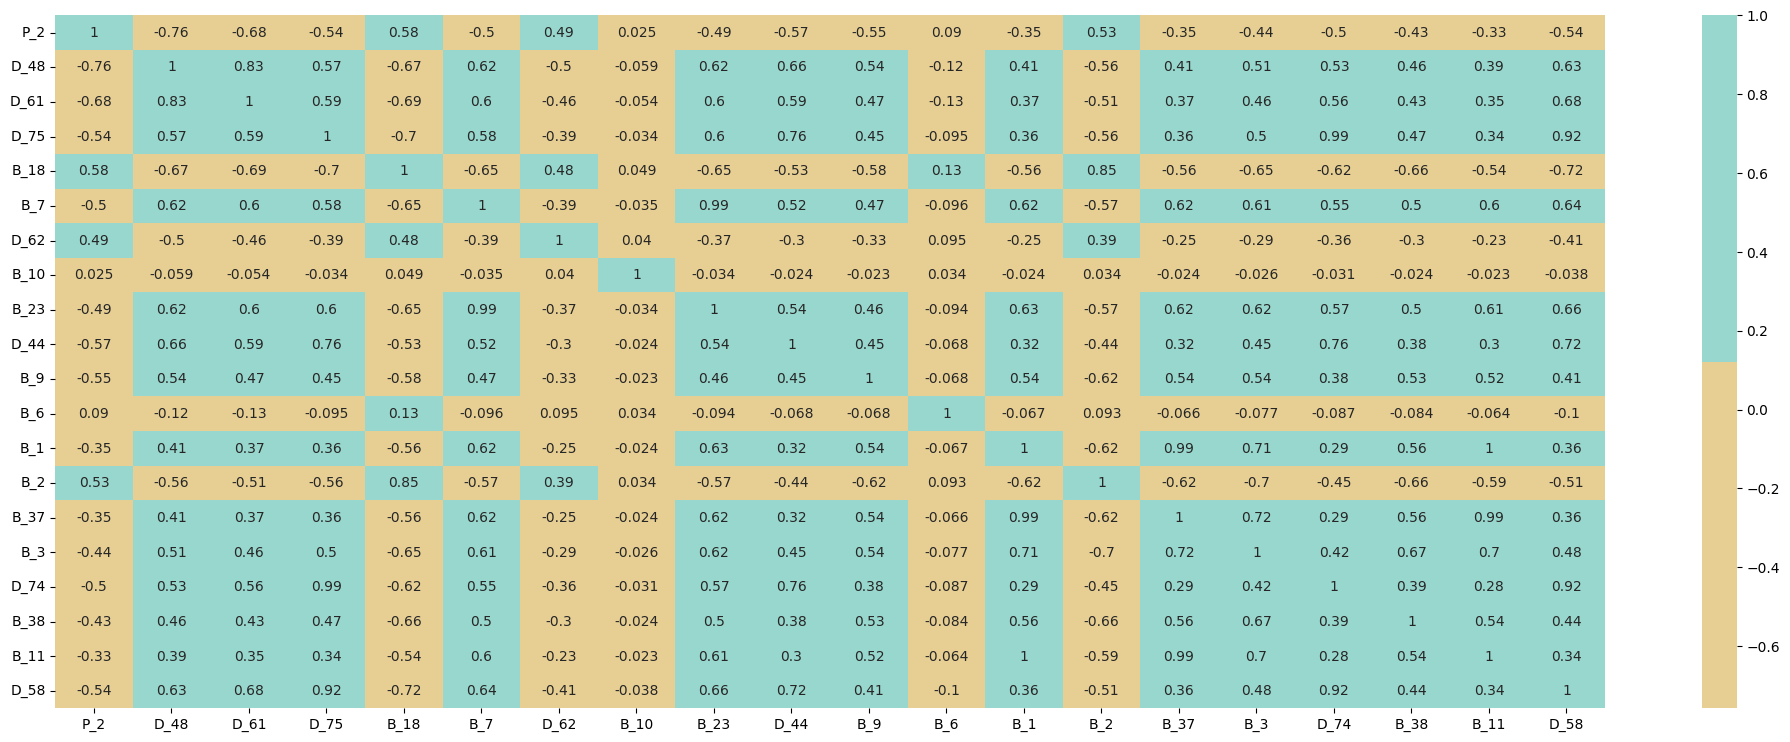

In [ ]:
top_cols = [col for col in selected_features[:20] if col in train_cols]
corr_df = train_df[top_cols].corr()
plt.figure(figsize=(25, 9))
sns.heatmap(corr_df,annot=True ,cmap=sns.color_palette("BrBG",2));
plt.show()

In [ ]:
def drop_feature_selection(row, col, corr, row_iv, col_iv):
    if row_iv >= col_iv:
        return col
    else:
        return row

In [ ]:
cor_matrix = train_df[train_cols].corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool_))
corr_df = upper_tri.stack().reset_index()
corr_df.columns = ['row', 'col', 'corr']
corr_df = corr_df.drop_duplicates()
corr_df = corr_df.sort_values('corr', ascending=False)
corr_df = corr_df.query("corr >= 0.8")
corr_df['row_iv'] = corr_df['row'].map(iv_score_dict)
corr_df['col_iv'] = corr_df['col'].map(iv_score_dict)

corr_df['drop_feature'] = corr_df.apply(lambda x: drop_feature_selection(x['row'], x['col'], x['corr'], x['row_iv'], x['col_iv']), axis=1)

In [ ]:
corr_df

,row,col,corr,row_iv,col_iv,drop_feature
809,D_62,D_77,0.999707,1.430638,1.044471,D_77
61,B_1,B_11,0.995640,1.217169,1.137052,B_11
512,B_7,B_23,0.994797,1.479162,1.424171,B_23
84,B_1,B_37,0.991985,1.217169,1.200160,B_37
980,S_22,S_24,0.990745,0.626414,0.533980,S_24
924,D_74,D_75,0.987546,1.179135,1.514600,D_74
687,B_11,B_37,0.987014,1.137052,1.200160,B_11
748,D_58,D_75,0.924636,1.118513,1.514600,D_58
747,D_58,D_74,0.921113,1.118513,1.179135,D_58
123,B_2,B_33,0.912601,1.214085,1.048962,B_33


In [ ]:
corr_drop_features = corr_df['drop_feature'].unique().tolist()

## Modeling

In [ ]:
# train valid split
train_data, valid_data = model_selection.train_test_split(train_df, test_size=0.3, random_state=42, shuffle=True, stratify=train_df['target'])

train_data.shape, valid_data.shape

((315251, 191), (135108, 191))

In [ ]:
selected_features = [col for col in selected_features if col not in corr_drop_features]
cat_cols = [col for col in cat_cols if col in selected_features]
train_cols = [col for col in train_df.columns if col in selected_features]

In [ ]:
X_train = train_data[train_cols].copy()
y_train = train_data[target_col].copy()

X_valid = valid_data[train_cols].copy()
y_valid = valid_data[target_col].copy()

X_test = test_df[train_cols].copy()

In [ ]:
# binning process

# selection_criteria = {
#     "iv": {"min": 0.02, "max": 1},
#     "quality_score": {"min": 0.01}
# }

binning_process = optbinning.BinningProcess(
    variable_names=train_cols,
    #selection_criteria=selection_criteria,
    categorical_variables=cat_cols
)

In [ ]:
# estimator
estimator = linear_model.LogisticRegression()

In [ ]:
# scorecard
scorecard = optbinning.Scorecard(
    binning_process=binning_process,
    estimator=estimator,
    scaling_method="min_max",
    scaling_method_params={"min": 300, "max": 850},
    # scaling_method = "pdo_odds",
    # scaling_method_params = {"pdo": 20, "odds": 50, "scorecard_points": 100},
    #intercept_based=True,
    #reverse_scorecard=True
)

In [ ]:
# model fitting
scorecard.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/optbinning/binning/transformations.py:38: RuntimeWarning: invalid value encountered in log
  return np.log((1. / event_rate - 1) * n_event / n_nonevent)


Scorecard(binning_process=BinningProcess(categorical_variables=['B_30', 'B_38'],
                                         variable_names=['P_2', 'B_1', 'R_1',
                                                         'S_3', 'B_3', 'D_42',
                                                         'D_44', 'B_4', 'D_45',
                                                         'D_47', 'D_48', 'B_6',
                                                         'B_7', 'B_8', 'D_51',
                                                         'B_9', 'D_52', 'B_10',
                                                         'B_14', 'D_62', 'B_17',
                                                         'B_18', 'B_19', 'B_20',
                                                         'B_22', 'D_75', 'B_25',
                                                         'B_28', 'B_30', 'S_22', ...]),
          estimator=LogisticRegression(), scaling_method='min_max',
          scaling_method_params={'max': 850, 'min': 300})

In [ ]:
# scorecard table
scorecard_df = scorecard.table(style="detailed")
scorecard_df.head()

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,P_2,0,"(-inf, 0.26)",20363,0.064593,3807,16556,0.813043,-2.529294,0.474862,0.047326,-0.477752,-24.575438
1,P_2,1,"[0.26, 0.39)",31318,0.099343,10409,20909,0.667635,-1.756896,0.374538,0.041595,-0.477752,-11.655129
2,P_2,2,"[0.39, 0.47)",27010,0.085678,12061,14949,0.553462,-1.274054,0.169047,0.019808,-0.477752,-3.578385
3,P_2,3,"[0.47, 0.56)",29401,0.093262,16993,12408,0.422026,-0.744927,0.059821,0.007309,-0.477752,5.272606
4,P_2,4,"[0.56, 0.61)",19655,0.062347,13904,5751,0.292597,-0.176584,0.002026,0.000253,-0.477752,14.779573


In [ ]:
# will try to understand scorecard for one feature

scorecard_df.query("Variable == 'P_2'")

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,P_2,0,"(-inf, 0.26)",20363,0.064593,3807,16556,0.813043,-2.529294,0.474862,0.047326,-0.477752,-24.575438
1,P_2,1,"[0.26, 0.39)",31318,0.099343,10409,20909,0.667635,-1.756896,0.374538,0.041595,-0.477752,-11.655129
2,P_2,2,"[0.39, 0.47)",27010,0.085678,12061,14949,0.553462,-1.274054,0.169047,0.019808,-0.477752,-3.578385
3,P_2,3,"[0.47, 0.56)",29401,0.093262,16993,12408,0.422026,-0.744927,0.059821,0.007309,-0.477752,5.272606
4,P_2,4,"[0.56, 0.61)",19655,0.062347,13904,5751,0.292597,-0.176584,0.002026,0.000253,-0.477752,14.779573
5,P_2,5,"[0.61, 0.68)",27130,0.086058,22181,4949,0.182418,0.440664,0.014881,0.001845,-0.477752,25.104599
6,P_2,6,"[0.68, 0.72)",15962,0.050633,14320,1642,0.102869,1.106355,0.045292,0.005389,-0.477752,36.239971
7,P_2,7,"[0.72, 0.76)",16539,0.052463,15453,1086,0.065663,1.595915,0.083992,0.009510,-0.477752,44.429095
8,P_2,8,"[0.76, 0.83)",31007,0.098357,29981,1026,0.033089,2.315509,0.267275,0.027507,-0.477752,56.466123
9,P_2,9,"[0.83, 0.86)",15835,0.050230,15579,256,0.016167,3.049115,0.193298,0.017734,-0.477752,68.737528


- We can observe that P_2 feature Points (score).
- While increasing bins the score also increasing
- For example if the user P_2 value is 0.73 then that user belongs to 7th bin corresponding score is 22.45

## Metrics

In [ ]:
def amex_metric(y_true, y_pred, return_components=False) -> float:
    """Amex metric for ndarrays"""
    def top_four_percent_captured(df) -> float:
        """Corresponds to the recall for a threshold of 4 %"""
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()

    def weighted_gini(df) -> float:
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(df) -> float:
        """Corresponds to 2 * AUC - 1"""
        df2 = pd.DataFrame({'target': df.target, 'prediction': df.target})
        df2.sort_values('prediction', ascending=False, inplace=True)
        return weighted_gini(df) / weighted_gini(df2)

    df = pd.DataFrame({'target': y_true.ravel(), 'prediction': y_pred.ravel()})
    df.sort_values('prediction', ascending=False, inplace=True)
    g = normalized_weighted_gini(df)
    d = top_four_percent_captured(df)

    if return_components: return g, d, 0.5 * (g + d)
    return 0.5 * (g + d)

In [ ]:
train_data['predict_proba'] = scorecard.predict_proba(X_train)[:, 1]
valid_data['predict_proba'] = scorecard.predict_proba(X_valid)[:, 1]

train_score = amex_metric(train_data['target'], train_data['predict_proba'])
valid_score = amex_metric(valid_data['target'], valid_data['predict_proba'])

print("Train Score :", train_score)
print("Valid Score :", valid_score)

/usr/local/lib/python3.10/dist-packages/optbinning/binning/transformations.py:38: RuntimeWarning: invalid value encountered in log
  return np.log((1. / event_rate - 1) * n_event / n_nonevent)
/usr/local/lib/python3.10/dist-packages/optbinning/binning/transformations.py:38: RuntimeWarning: invalid value encountered in log
  return np.log((1. / event_rate - 1) * n_event / n_nonevent)
<ipython-input-46-ef6b607304d9>:26: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  df = pd.DataFrame({'target': y_true.ravel(), 'prediction': y_pred.ravel()})
<ipython-input-46-ef6b607304d9>:26: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  df = pd.DataFrame({'target': y_true.ravel(), 'prediction': y_pred.ravel()})


Train Score : 0.6394763443539377
Valid Score : 0.6385338278133454


Train Threshold value is: 0.22989850013167695
Valid Threshold value is: 0.2413451841957608


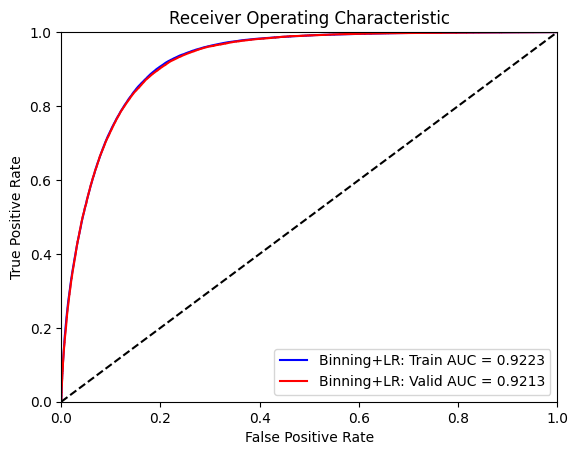

In [ ]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_data['predict_proba'])
optimal_idx = np.argmax(true_positive_rate - false_positive_rate)
optimal_threshold = thresholds[optimal_idx]
auc_score = metrics.auc(false_positive_rate, true_positive_rate)
print("Train Threshold value is:", optimal_threshold)

false_positive_rate1, true_positive_rate1, thresholds = metrics.roc_curve(y_valid, valid_data['predict_proba'])
optimal_idx = np.argmax(true_positive_rate1 - false_positive_rate1)
optimal_threshold1 = thresholds[optimal_idx]
auc_score1 = metrics.auc(false_positive_rate1, true_positive_rate1)
print("Valid Threshold value is:", optimal_threshold1)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='Binning+LR: Train AUC = {0:.4f}'.format(auc_score))
plt.plot(false_positive_rate1, true_positive_rate1, 'r', label='Binning+LR: Valid AUC = {0:.4f}'.format(auc_score1))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
train_data['predict'] = (train_data['predict_proba'] > optimal_threshold).astype(int)
valid_data['predict'] = (valid_data['predict_proba'] > optimal_threshold).astype(int)

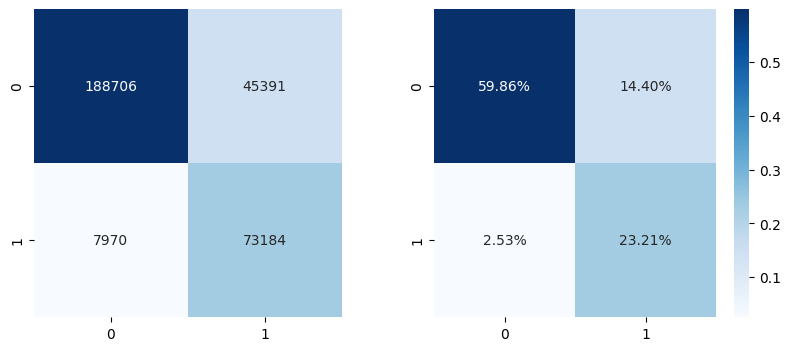

In [ ]:
conf_mat = metrics.confusion_matrix(train_data['target'], train_data['predict'])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax1)
sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, fmt='.2%', cmap='Blues', ax=ax2)
plt.show()

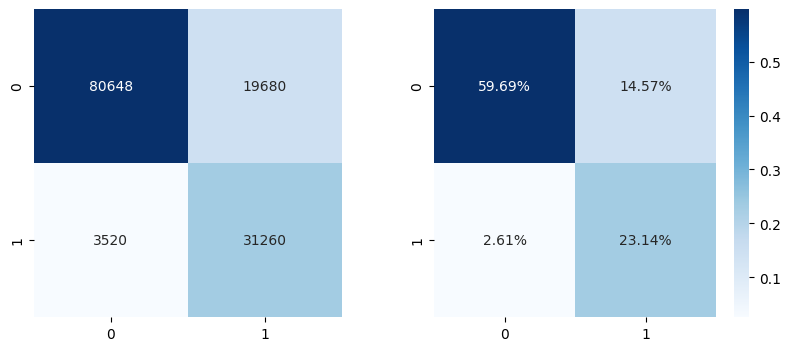

In [ ]:
conf_mat = metrics.confusion_matrix(valid_data['target'], valid_data['predict'])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax1)
sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, fmt='.2%', cmap='Blues', ax=ax2)
plt.show()

In [ ]:
print(metrics.classification_report(train_data['target'], train_data['predict'], labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88    234097
           1       0.62      0.90      0.73     81154

    accuracy                           0.83    315251
   macro avg       0.79      0.85      0.80    315251
weighted avg       0.87      0.83      0.84    315251



In [ ]:
print(metrics.classification_report(valid_data['target'], valid_data['predict'], labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.96      0.80      0.87    100328
           1       0.61      0.90      0.73     34780

    accuracy                           0.83    135108
   macro avg       0.79      0.85      0.80    135108
weighted avg       0.87      0.83      0.84    135108



## Scores

In [ ]:
train_data['score'] = scorecard.score(X_train)
valid_data['score'] = scorecard.score(X_valid)

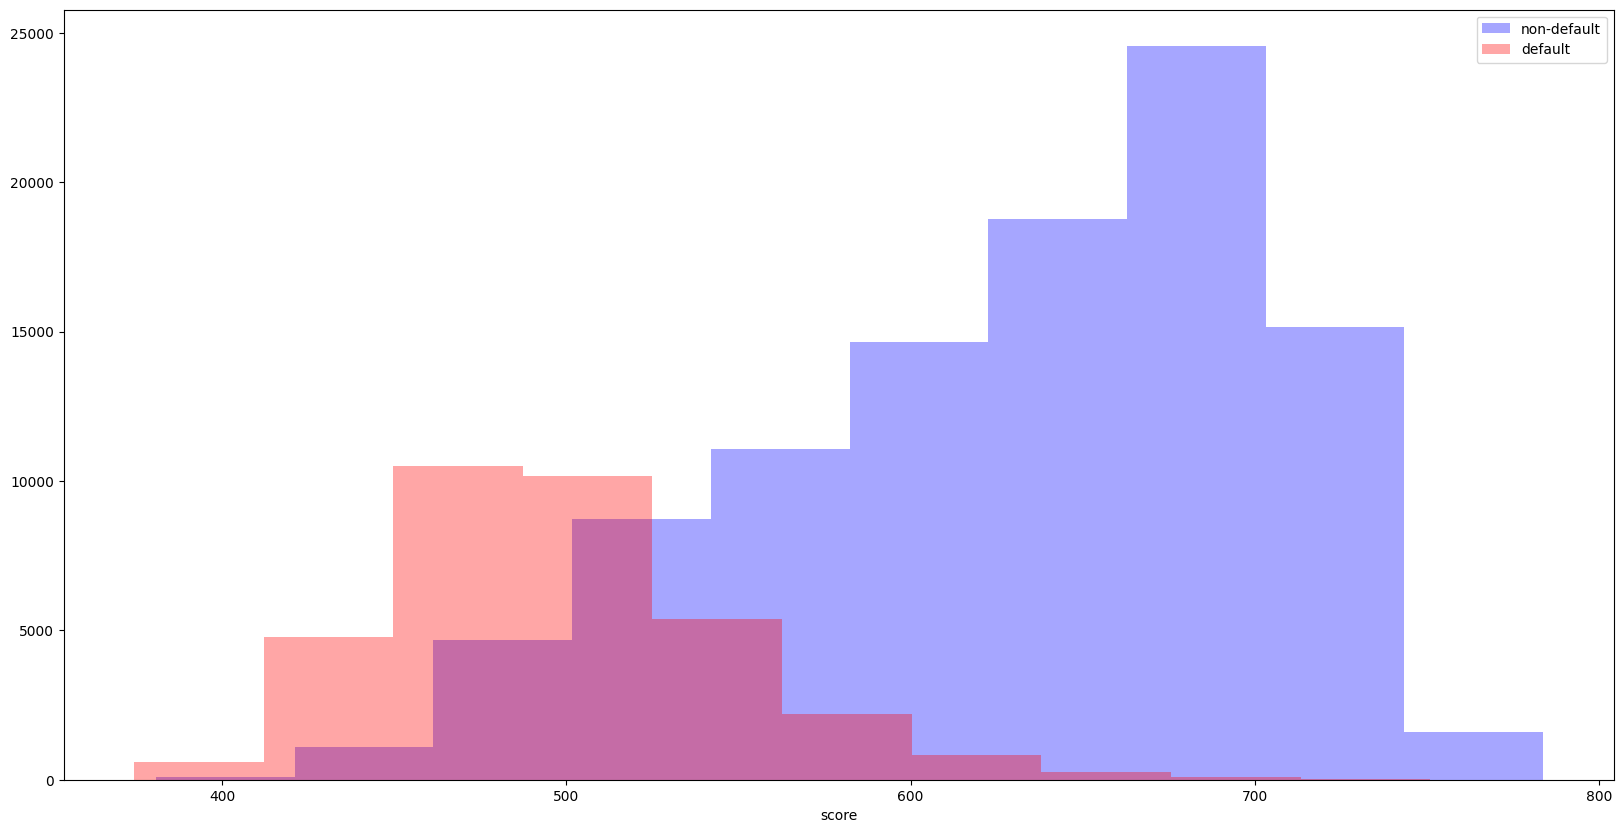

In [ ]:
y_test = valid_data['target']
score = valid_data['score']

mask = y_test == 0

fig, ax = plt.subplots(figsize=(20,10))
plt.hist(score[mask], label="non-default", color="b", alpha=0.35)
plt.hist(score[~mask], label="default", color="r", alpha=0.35)
plt.xlabel("score")
plt.legend()
plt.show()

- We can observe that default vs non-default score distribution
- Some overlap between 550 to 650
overall well seperated

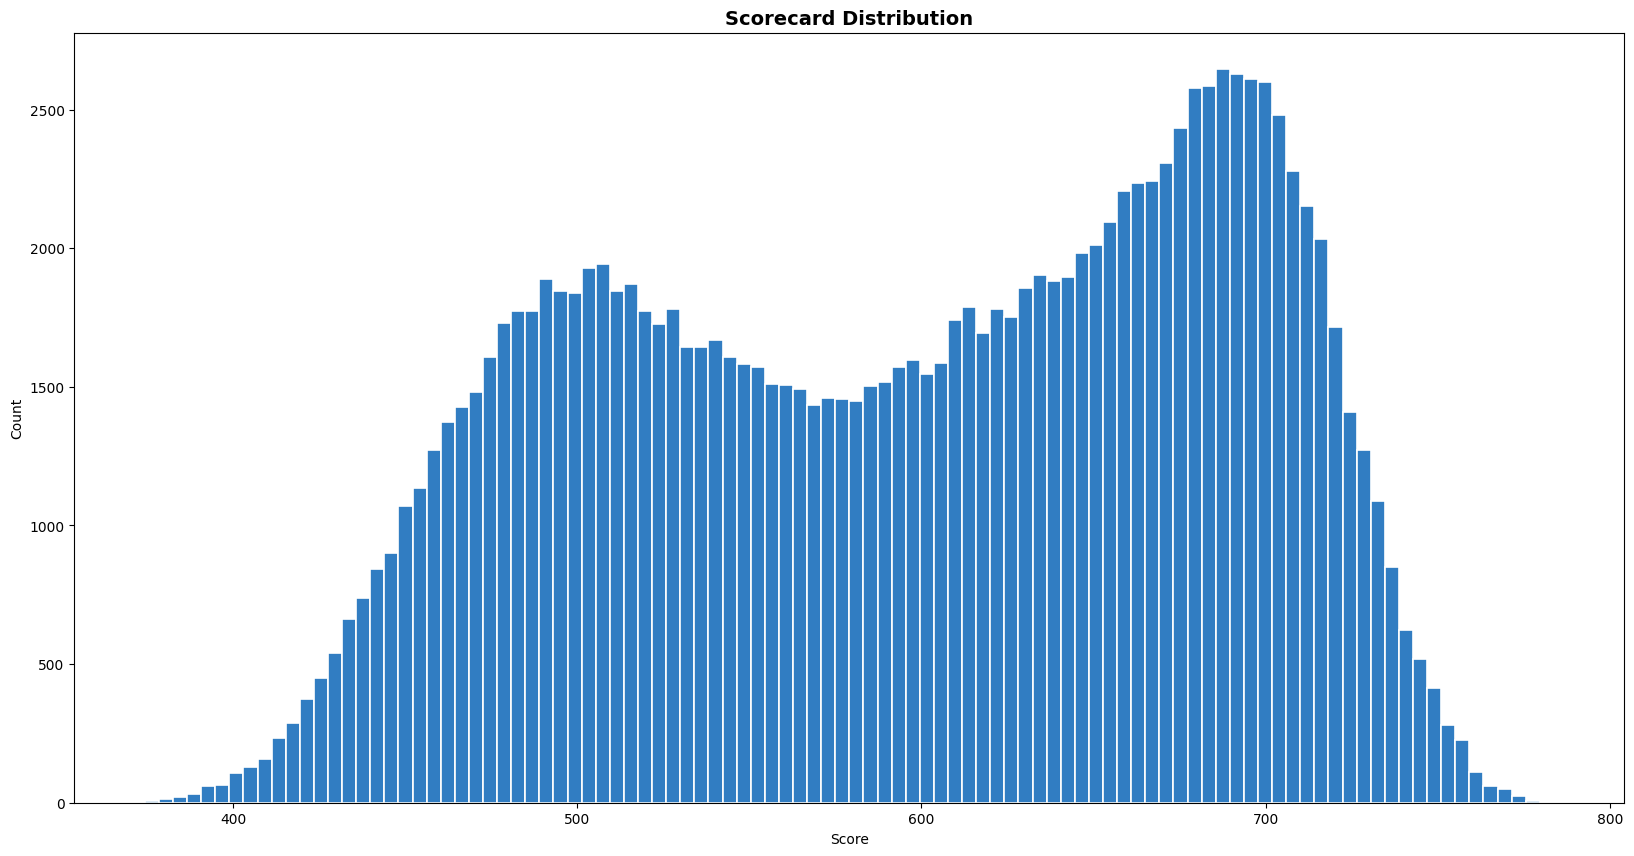

In [ ]:
# Plot Distribution of Scores
plt.figure(figsize=(20,10))

plt.hist(score,
         bins=100,
         edgecolor='white',
         color = '#317DC2',
         linewidth=1.2)

#plt.xlim(231,750)
plt.title('Scorecard Distribution', fontweight="bold", fontsize=14)
# plt.axvline(score.mean(), color='k', linestyle='dashed', linewidth=1.5, alpha=0.5)
# plt.text(458, 2970, 'Mean Score: 456', color='red', fontweight='bold', style='italic', fontsize=8)
plt.xlabel('Score')
plt.ylabel('Count');

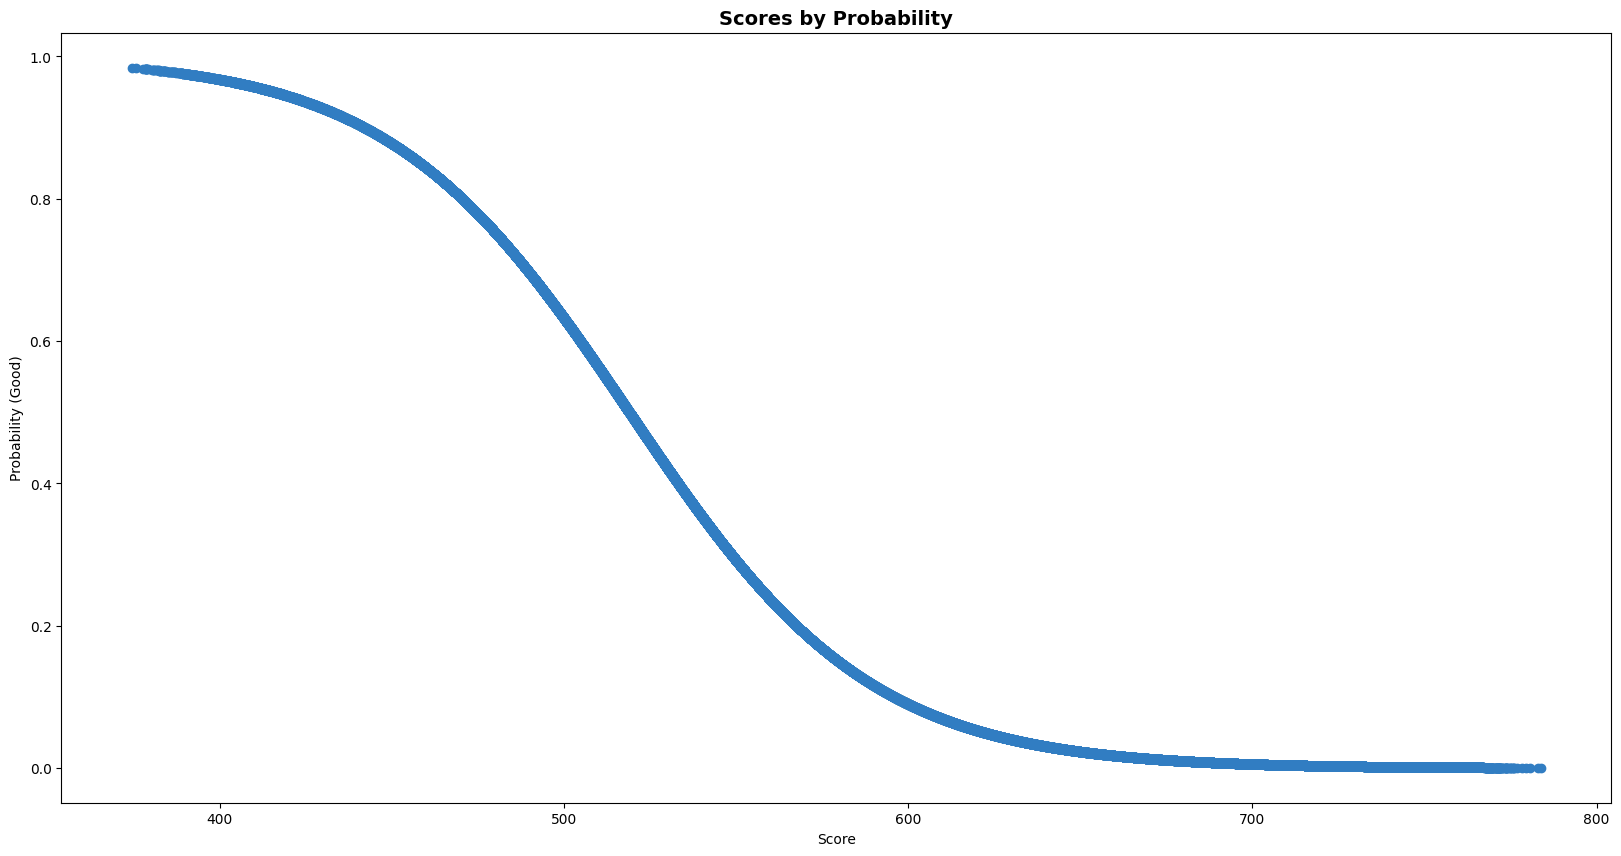

In [ ]:
# Plot Scores Against Probabilities
plt.figure(figsize=(20,10))

plt.scatter(x=score,
            y=valid_data['predict_proba'],
            #data=scorecard,
            color='#317DC2')

plt.title('Scores by Probability', fontweight="bold", fontsize=14)
plt.xlabel('Score')
plt.ylabel('Probability (Good)');